### Stationarity

We’re handling here a time series. As such, it’s very important the concept of [Stationarity](https://www.investopedia.com/articles/trading/07/stationary.asp). Much of the analysis carried out on financial time series data involves identifying if the series we want to predict is stationary, and if it is not, finding ways to transform it such that it is stationary. A time series is said to be stationary if its mean and variance don’t change over time, this means, it doesn’t show trends or seasonal effects. 

In [11]:
import numpy as np
import pandas as pd

Let's check stationarity by using [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test).

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:
- **Null Hypothesis**: The series has a unit root (value of a =1)
- **Alternate Hypothesis**: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


In [12]:
from utils import get_apple_stock, adf_test

In [13]:
apple_stock = get_apple_stock()

In [14]:
adf_test(apple_stock['Close'])

Results of Dickey-Fuller Test:
Test Statistic                    1.059025
p-value                           0.994851
Lags Used                        37.000000
Number of Observations Used    9661.000000
Critical Value (1%)              -3.431027
Critical Value (5%)              -2.861839
Critical Value (10%)             -2.566929
dtype: float64


Let's try differencing

In [15]:
from utils import difference

In [16]:
diffed_series, _ = difference(apple_stock['Close'])

In [17]:
adf_test(diffed_series)

Results of Dickey-Fuller Test:
Test Statistic                -1.623412e+01
p-value                        3.785250e-29
Lags Used                      3.600000e+01
Number of Observations Used    9.661000e+03
Critical Value (1%)           -3.431027e+00
Critical Value (5%)           -2.861839e+00
Critical Value (10%)          -2.566929e+00
dtype: float64


We can see that our statistic value of -16 is less than the value of -3.431 at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [18]:
from utils import plot_series

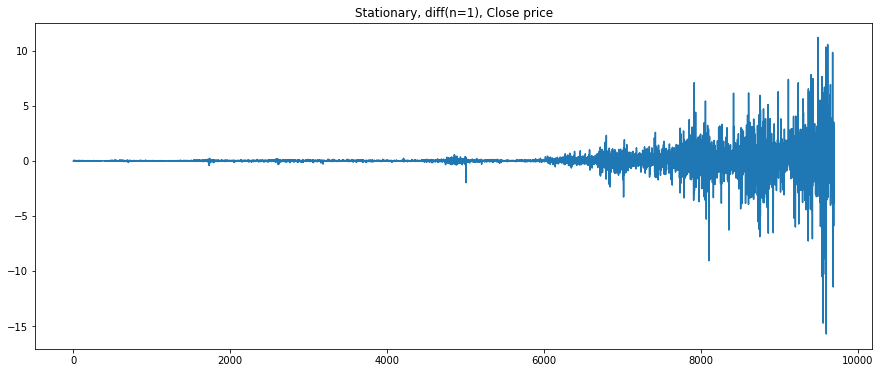

In [19]:
plot_series(diffed_series, 'Stationary, diff(n=1), Close price')

Let's use [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html) and see if this transformation helps to make the series stationary

In [20]:
from scipy.stats import boxcox

In [21]:
boxcox_series, lmbda = boxcox(apple_stock['Close'])
print('Best lmbda for Box-Cox test:', lmbda)

Best lmbda for Box-Cox test: -0.21450764733744443


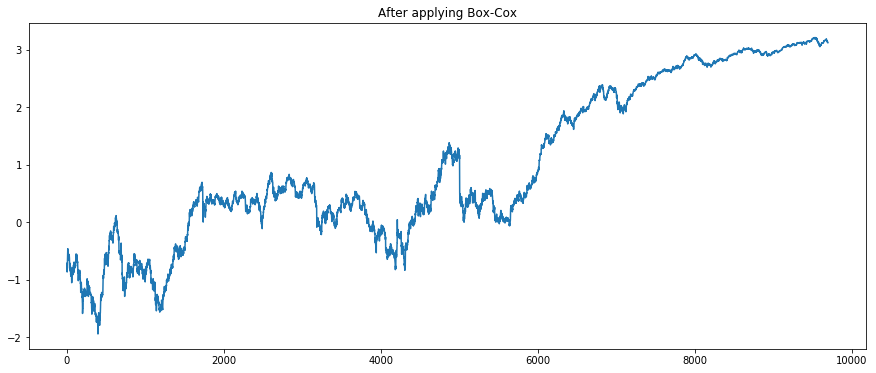

In [22]:
plot_series(boxcox_series, 'After applying Box-Cox')

In [23]:
adf_test(boxcox_series)

Results of Dickey-Fuller Test:
Test Statistic                   -0.777802
p-value                           0.825556
Lags Used                        17.000000
Number of Observations Used    9681.000000
Critical Value (1%)              -3.431026
Critical Value (5%)              -2.861839
Critical Value (10%)             -2.566929
dtype: float64


### Trend and Seasonality

A trend can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models. Alternately, a trend can be added, either directly or as a summary, as a new input variable to the supervised learning problem to predict the output variable.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

In [25]:
X = np.array([i for i in range(0, len(apple_stock))]).reshape(-1, 1)
y = np.array(apple_stock['Close']).reshape(-1, 1)

In [26]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
trend = linear_regressor.predict(X)

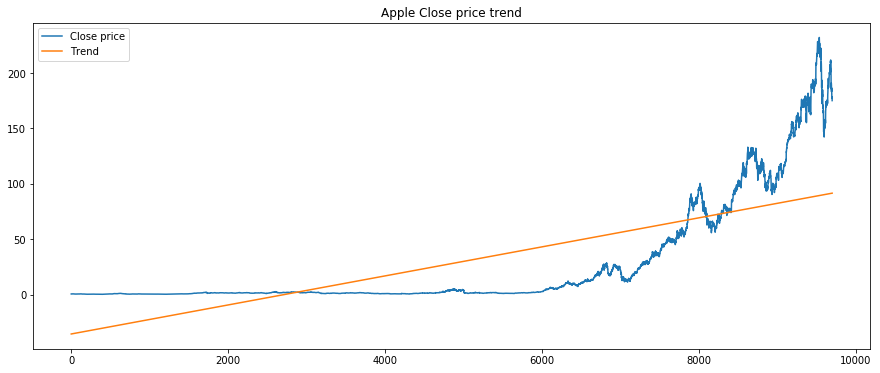

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(y)
plt.plot(trend)
ax.set_title('Apple Close price trend')
ax.legend(['Close price', 'Trend'])

In [29]:
detrended_price = [y[i]-trend[i] for i in range(0, len(apple_stock))]

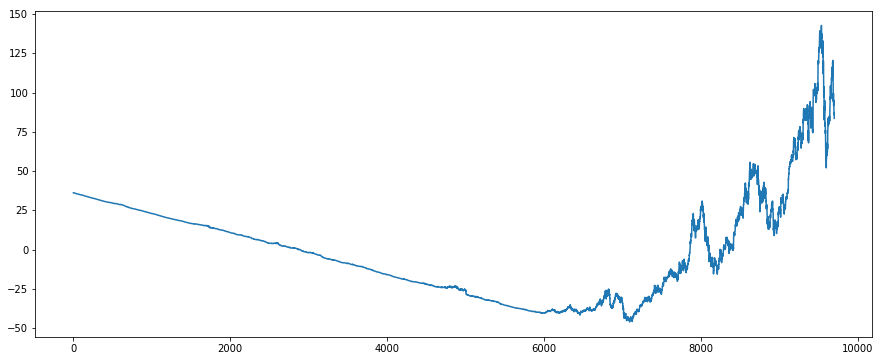

In [30]:
plot_series(detrended_price)

There seems to be a parabola in the residuals, suggesting that perhaps a polynomial fit may have done a better job

In [31]:
from numpy import polyfit

In [32]:
degree = 4
X1d = X.flatten()
y1d = y.flatten()
coef = polyfit(X1d, y1d, degree) 
print('Coefficients: %s' % coef)

Coefficients: [ 7.54975843e-14 -6.34433691e-10  1.09347483e-06  1.11302440e-03
 -6.38839677e-01]


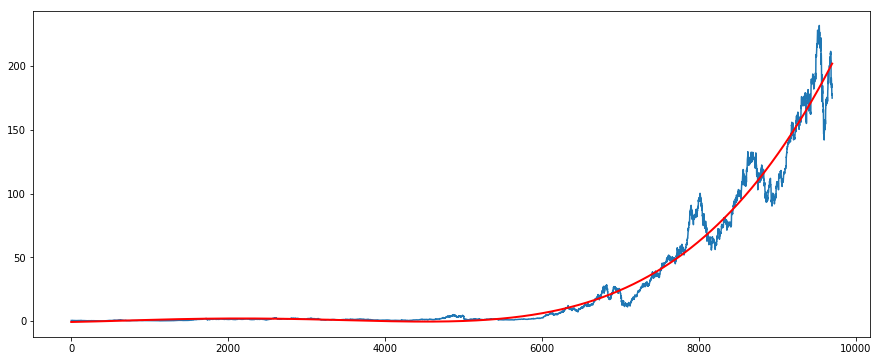

In [33]:
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
    
# plot curve over original data
plt.subplots(figsize=(15, 6))
plt.plot(y)
plt.plot(curve, color='red', linewidth=2)

In [34]:
detrended_price = np.array([y[i]-curve[i] for i in range(0, len(apple_stock))]).flatten()

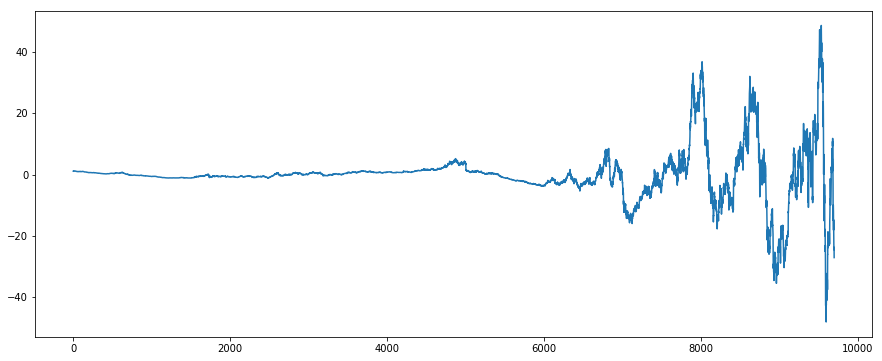

In [35]:
plot_series(detrended_price)

In [36]:
adf_test(detrended_price)

Results of Dickey-Fuller Test:
Test Statistic                -5.821144e+00
p-value                        4.180219e-07
Lags Used                      3.700000e+01
Number of Observations Used    9.661000e+03
Critical Value (1%)           -3.431027e+00
Critical Value (5%)           -2.861839e+00
Critical Value (10%)          -2.566929e+00
dtype: float64


Let's have a look at other plots that might gives as a hint about its trend and seasonality:

In [37]:
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

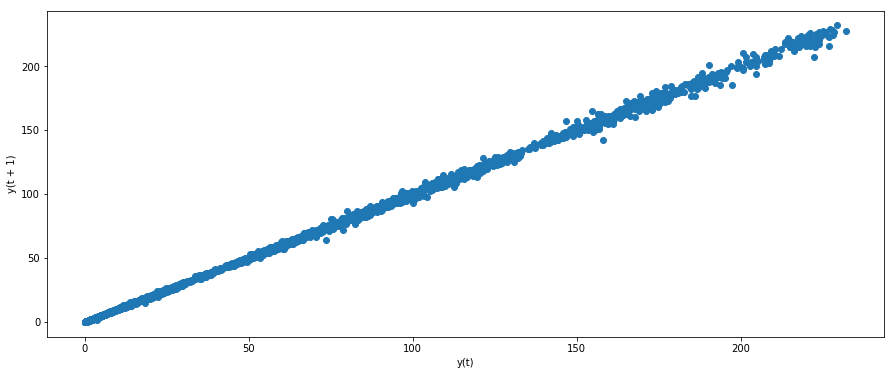

In [38]:
fig, ax = plt.subplots(figsize=(15, 6))
lag_plot(apple_stock['Close'], lag=1, ax=ax)

Let's have a look at the correlation at lag=10

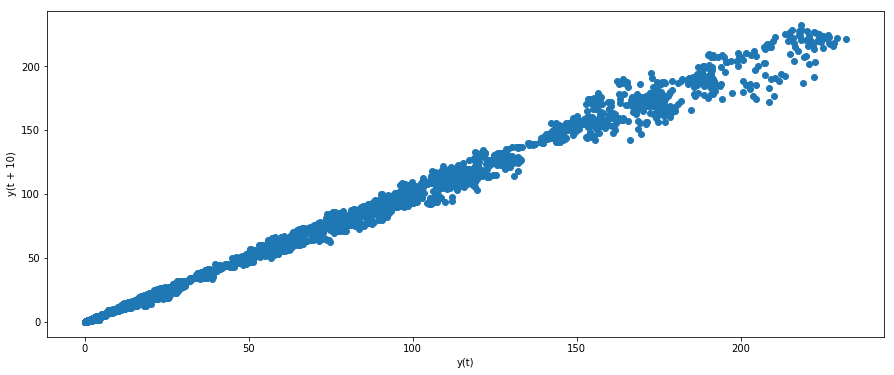

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))
lag_plot(apple_stock['Close'], lag=10, ax=ax)

We can see a linear pattern that indicates the data is not random, with a positive and strong correlation (autocorrelation is present). Let's remove trend and confirm we get [white noise](https://www.quantstart.com/articles/White-Noise-and-Random-Walks-in-Time-Series-Analysis)

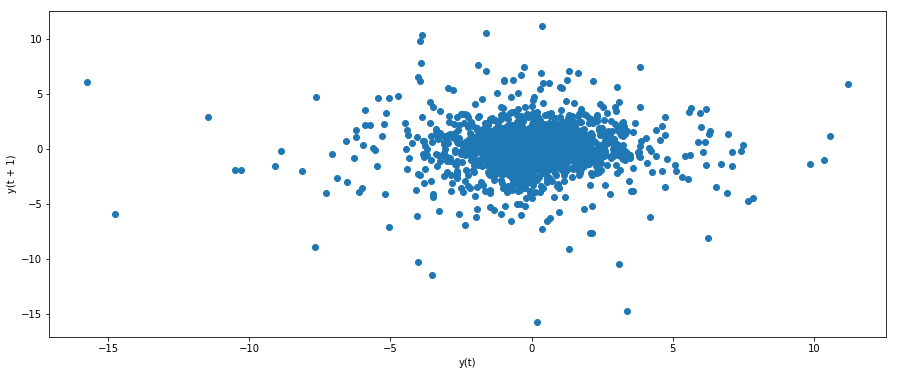

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))
lag_plot(pd.Series(diffed_series), ax=ax)

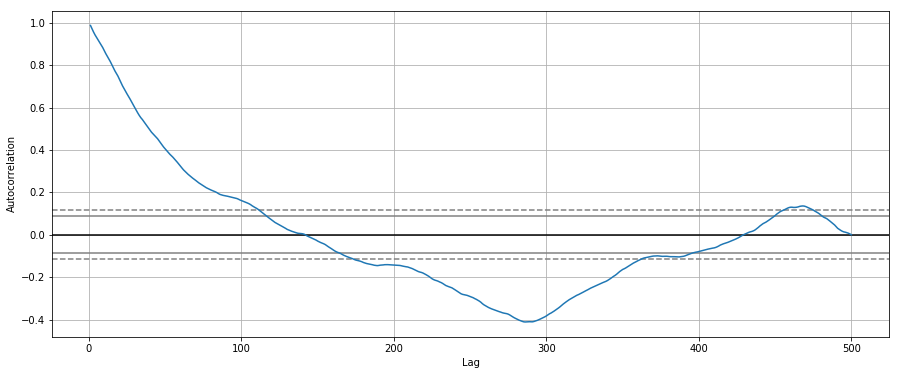

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))
autocorrelation_plot(apple_stock['Close'][:500], ax=ax)

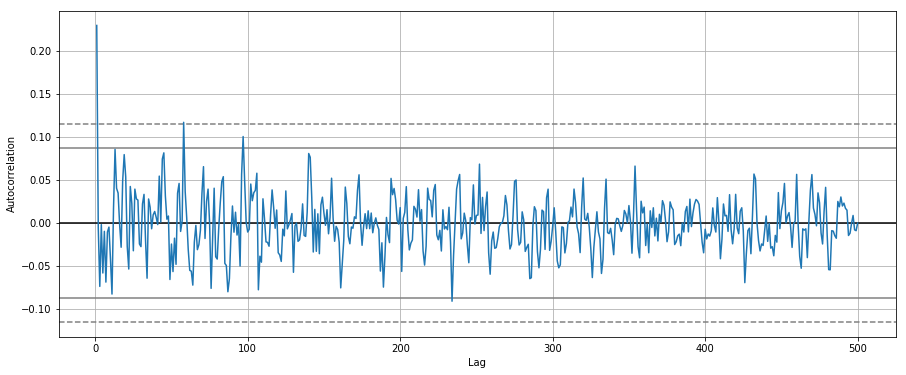

In [52]:
fig, ax = plt.subplots(figsize=(15, 6))
autocorrelation_plot(pd.Series(diffed_series[:500]), ax=ax)

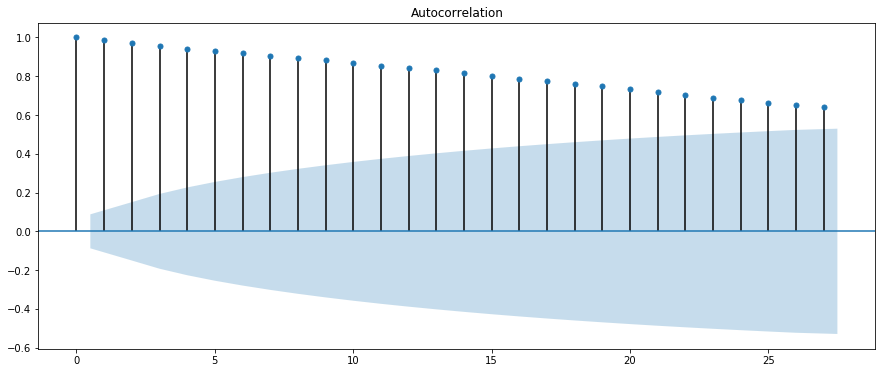

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))
_ = plot_acf(apple_stock['Close'][:500], ax=ax)

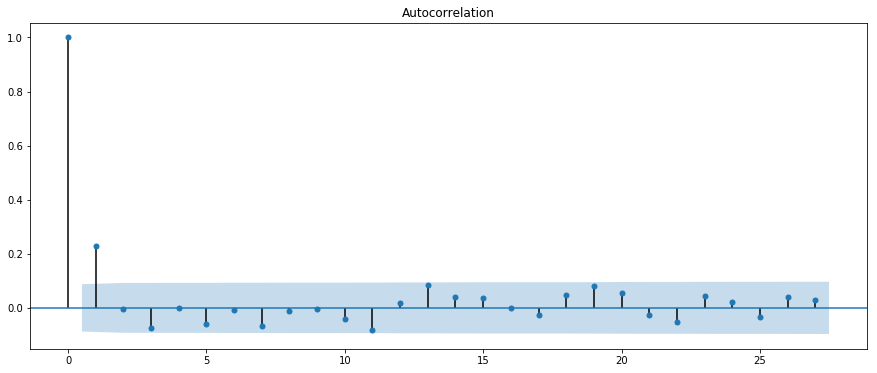

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))
_ = plot_acf(pd.Series(diffed_series[:500]), ax=ax)

Decomposing the time series

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [46]:
result = seasonal_decompose(apple_stock['Close'], freq=1)

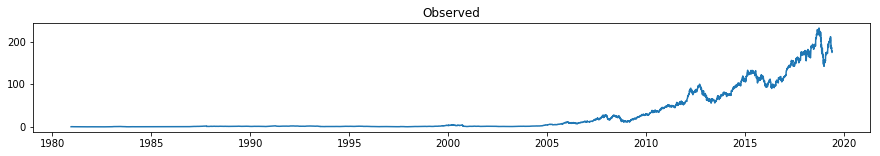

In [47]:
plot_series(result.observed, title='Observed', figsize=(15, 2))

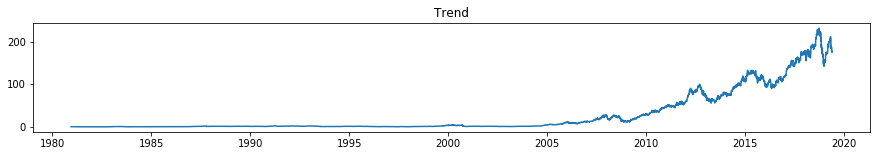

In [48]:
plot_series(result.trend, title='Trend', figsize=(15, 2))

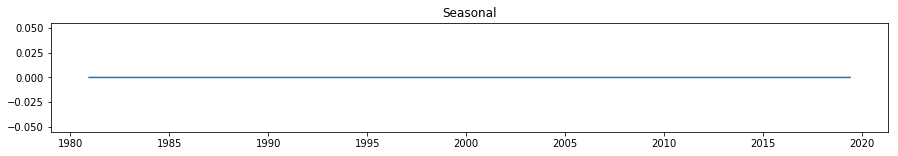

In [49]:
plot_series(result.seasonal, title='Seasonal', figsize=(15, 2))

We can confirm this timeseries is not seasonal

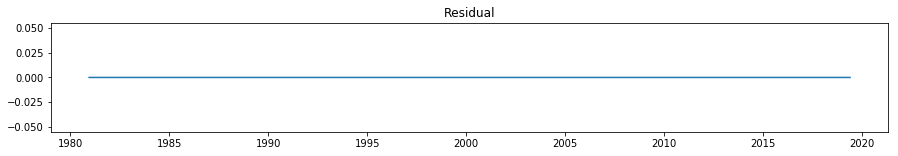

In [50]:
plot_series(result.resid, title='Residual', figsize=(15, 2))